In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
#from ridgeplot import ridgeplot
import joypy
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.stats.api as sms

In [39]:
#generam datele de venit

n_observations = 100000

#normal distributed scenario
# mean_income = 10000
# std_income = 3000
# incomes = np.random.normal(loc=mean_income, scale=std_income,size=n_observations)

#uniform distributed
low_param = 2000
high_param = 25000
incomes = np.random.uniform(low=low_param, high=high_param,size=n_observations)

df = pd.DataFrame({'income':incomes})
df


,income
0,13373.774289
1,3614.816051
2,16004.896410
3,3234.572615
4,16813.449523
...,...
99995,15274.629260
99996,17153.319896
99997,5436.854525
99998,15616.886043


<Axes: xlabel='income', ylabel='Count'>

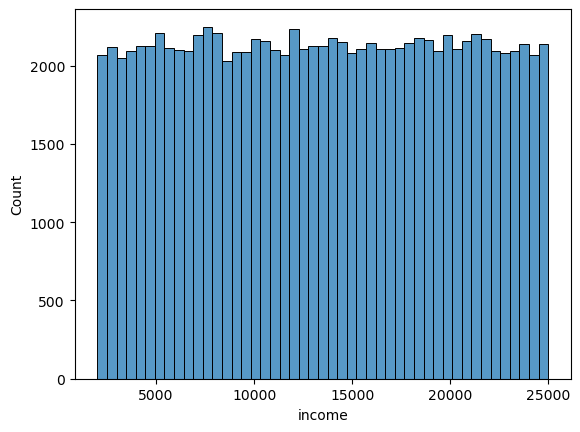

In [40]:
sns.histplot(data=df, x='income')

In [63]:
b0 = 1000
b1 = 0.6
error_mean = 0
error_std = 500

def generate_consumption(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model.
    
    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with specified mean and standard deviation.
    
    Parameters:
        x (float): The independent variable value.
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The mean of the normally distributed error term.
        error_std (float): The standard deviation of the normally distributed error term.
    
    Returns:
        float: The generated dependent variable (y) value.
    
    Example:
        >>> generate_consumption(2.0, 1.0, 0.5, 0.0, 1.0)
        2.47
    """
    error = np.random.normal(loc=error_mean, scale=error_std)
    y = beta0 + beta1 * x + error
    return y


def generate_consumption_v2(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model with heteroscedastic errors.

    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with a mean of `error_mean` and a standard deviation that scales with `x`.
    Specifically, the standard deviation of the error term increases as `x` increases, simulating heteroscedasticity.

    Parameters:
        x (float): The independent variable value (e.g., income).
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The mean of the normally distributed error term.
        error_std (float): The base standard deviation of the normally distributed error term.

    Returns:
        float: The generated dependent variable (y) value (e.g., consumption).

    Example:
        >>> generate_consumption_v2(1000.0, 50.0, 0.8, 0.0, 10.0)
        850.23  # Example output, actual value will vary due to randomness
    """
    # Generate an updated error standard deviation that scales with x
    error_std_updated = x * 0.0005 * error_std
    
    # Simulate the consumption value (y) using the linear model and heteroscedastic error
    y = beta0 + beta1 * x + np.random.normal(loc=error_mean, scale=error_std_updated)
    
    return y


def generate_consumption_v3(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model with conditional bias in the error term.

    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with a mean that is conditionally updated based on the value of `x`:
        - If 7000 < x < 9000, the error mean is increased by x * 0.3.
        - If 9000 < x < 11000, the error mean is decreased by x * 0.3.
    Outside these ranges, the error mean remains unchanged.

    Parameters:
        x (float): The independent variable value (e.g., income).
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The base mean of the normally distributed error term.
        error_std (float): The standard deviation of the normally distributed error term.

    Returns:
        float: The generated dependent variable (y) value (e.g., consumption).

    Example:
        >>> generate_consumption_v3(8000.0, 50.0, 0.8, 0.0, 10.0)
        6450.23  # Example output, actual value will vary due to randomness
    """
    # Initialize the updated error mean with the base value
    error_mean_updated = error_mean

    # Conditionally update the error mean based on the value of x
    if (x > 7000) and (x < 9000):
        error_mean_updated = error_mean + x * 0.3
    elif (x > 9000) and (x < 11000):
        error_mean_updated = error_mean - x * 0.3

    # Simulate the consumption value (y) using the linear model and updated error mean
    y = beta0 + beta1 * x + np.random.normal(loc=error_mean_updated, scale=error_std)

    return y


def generate_consumption_v4(x: float, beta0: float, beta1: float, error_mean: float, error_std: float) -> float:
    """
    Generate a simulated consumption value (y) based on a linear regression model with violations of non-biased errors
    and homoscedasticity, and an additional trend in errors for high values of x.

    The model follows the equation:
        y = beta0 + beta1 * x + error
    where 'error' is drawn from a normal distribution with:
        - A randomly updated mean (`error_mean_updated`) between -200 and 200.
        - A randomly updated standard deviation (`error_std_updated`) between 0 and 800.
    Additionally, for x > 17000, the error mean is further increased by x * 0.5, introducing a trend of bias for high values of x.

    Parameters:
        x (float): The independent variable value (e.g., income).
        beta0 (float): The intercept of the linear model.
        beta1 (float): The coefficient for the independent variable.
        error_mean (float): The base mean of the normally distributed error term (unused in this version).
        error_std (float): The base standard deviation of the normally distributed error term (unused in this version).

    Returns:
        float: The generated dependent variable (y) value (e.g., consumption).

    Example:
        >>> generate_consumption_v4(18000.0, 50.0, 0.8, 0.0, 10.0)
        14450.23  # Example output, actual value will vary due to randomness
    """
    # Randomly update the error mean and standard deviation
    error_mean_updated = np.random.uniform(-200, 200)
    error_std_updated = np.random.uniform(0, 800)

    # Introduce a trend of bias for high values of x
    if x > 17000:
        error_mean_updated = abs(error_mean_updated) + x * 0.5

    # Simulate the consumption value (y) using the linear model and updated error parameters
    y = beta0 + beta1 * x + np.random.normal(loc=error_mean_updated, scale=error_std_updated)

    return y


In [64]:
df['consumption_v1'] = df['income'].apply(generate_consumption, args=(b0, b1, error_mean, error_std))
df['consumption_v2'] = df['income'].apply(generate_consumption_v2, args=(b0, b1, error_mean, error_std))
df['consumption_v3'] = df['income'].apply(generate_consumption_v3, args=(b0, b1, error_mean, error_std))
df['consumption_v4'] = df['income'].apply(generate_consumption_v4, args=(b0, b1, error_mean, error_std))

df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4
0,13373.774289,8582.676255,1127.229662,9681.245555,9093.037354,9024.347725,9024.551293,8973.907469,12634.263451,-28.814861,-47.484429,11.080194,-4248.810788
1,3614.816051,3187.817822,3142.744811,3107.785334,1937.268898,3168.954247,3169.093417,3173.076793,423.860661,7.752111,-33.861293,-12.853131,2208.994026
2,16004.896410,10798.079397,6023.693053,11277.838466,10780.310136,10603.025995,10603.246925,10537.875009,15926.321896,-50.795104,-9.122931,135.262087,-5760.886837
3,3234.572615,2986.192799,3687.481470,2697.775492,2627.354850,2940.807464,2940.944124,2947.055968,-51.899702,-33.873039,111.034013,17.005694,2977.159418
4,16813.449523,11121.628029,8331.252798,10591.575931,10522.932426,11088.159399,11088.385664,11018.487754,16937.983075,-57.892574,546.956485,28.380893,-5979.831523


In [65]:
#definim cazurile de consum
scenarii_simulate_versiuni = [1,2,3,4]
scenarii_simulate_denumiri = [f'consumption_v{i}' for i in scenarii_simulate_versiuni]


In [66]:
#estimam 4 modele pentru cele 4 relatii
df_sample = df.sample(50000)
df_sample['intercept'] = 1
print(f"Rezultate modele estimate\n")
for scenariu in scenarii_simulate_versiuni:
    formula = f"consumption_v{scenariu}~income"
    nume_model = f'model_v{scenariu}'
    globals()[nume_model] = smf.ols(formula=formula,data=df_sample).fit()
    print(f"Versiunea {scenariu}:\n")
    print(eval(nume_model).summary())
    print("\n\n")


Rezultate modele estimate

Versiunea 1:

                            OLS Regression Results                            
Dep. Variable:         consumption_v1   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.183e+06
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:53:05   Log-Likelihood:            -3.8154e+05
No. Observations:               50000   AIC:                         7.631e+05
Df Residuals:                   49998   BIC:                         7.631e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

In [67]:
#scriem predictiile
for scenariu in scenarii_simulate_versiuni:
    nume_model = f'model_v{scenariu}'
    df[f"pred_v{scenariu}"] = globals()[nume_model].predict(df['income'])


#calculam erorile
for scenariu in scenarii_simulate_versiuni:
    df[f"error_v{scenariu}"] = df[f'consumption_v{scenariu}'] - df[f'pred_v{scenariu}']

df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4
0,13373.774289,8582.676255,1127.229662,9681.245555,9093.037354,9025.688370,9041.168134,8976.611274,12633.354162,-443.012115,-7913.938471,704.634281,-3540.316808
1,3614.816051,3187.817822,3142.744811,3107.785334,1937.268898,3171.003687,3145.183489,3171.930827,433.025694,16.814135,-2.438679,-64.145494,1504.243205
2,16004.896410,10798.079397,6023.693053,11277.838466,10780.310136,10604.175541,10630.790227,10541.616754,15922.696460,193.903856,-4607.097174,736.221712,-5142.386324
3,3234.572615,2986.192799,3687.481470,2697.775492,2627.354850,2942.884520,2915.455131,2945.760002,-42.342138,43.308280,772.026339,-247.984510,2669.696989
4,16813.449523,11121.628029,8331.252798,10591.575931,10522.932426,11089.250220,11119.286707,11022.548462,16933.522957,32.377809,-2788.033909,-430.972531,-6410.590531


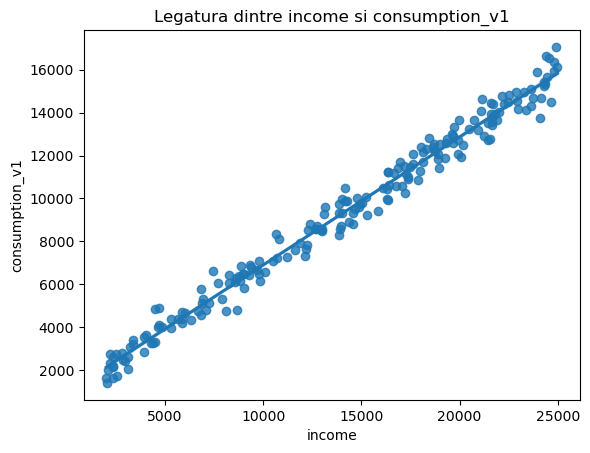

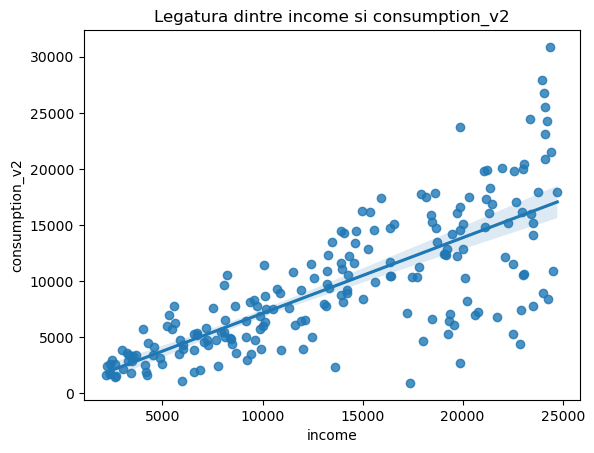

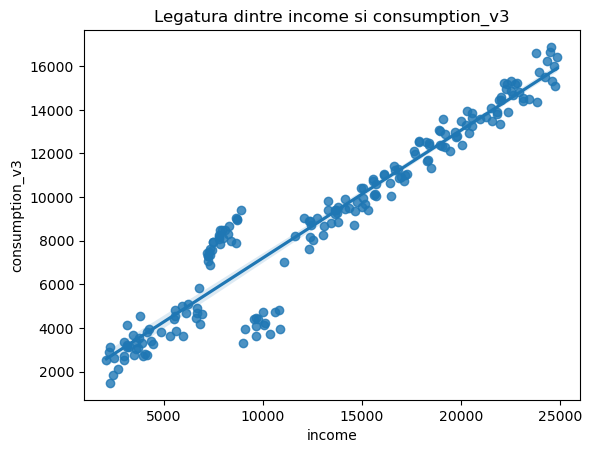

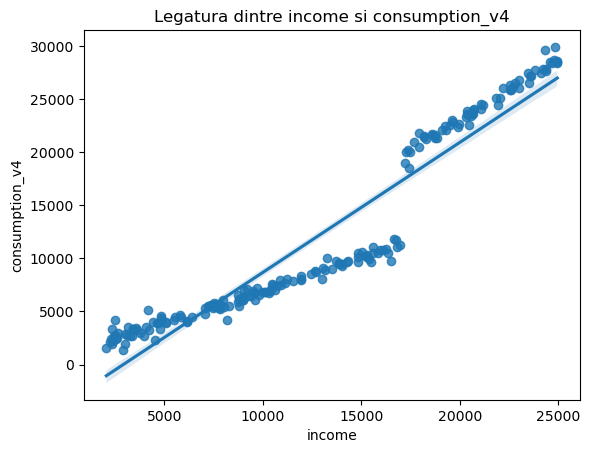

In [68]:
#liniaritate

for scenariu in scenarii_simulate_denumiri:
    relationship_plot = sns.regplot(data=df.sample(200), x='income',y=scenariu)
    relationship_plot.set_title(f"Legatura dintre income si {scenariu}")
    plt.show()


In [71]:
df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4
0,13373.774289,8582.676255,1127.229662,9681.245555,9093.037354,9025.688370,9041.168134,8976.611274,12633.354162,-443.012115,-7913.938471,704.634281,-3540.316808
1,3614.816051,3187.817822,3142.744811,3107.785334,1937.268898,3171.003687,3145.183489,3171.930827,433.025694,16.814135,-2.438679,-64.145494,1504.243205
2,16004.896410,10798.079397,6023.693053,11277.838466,10780.310136,10604.175541,10630.790227,10541.616754,15922.696460,193.903856,-4607.097174,736.221712,-5142.386324
3,3234.572615,2986.192799,3687.481470,2697.775492,2627.354850,2942.884520,2915.455131,2945.760002,-42.342138,43.308280,772.026339,-247.984510,2669.696989
4,16813.449523,11121.628029,8331.252798,10591.575931,10522.932426,11089.250220,11119.286707,11022.548462,16933.522957,32.377809,-2788.033909,-430.972531,-6410.590531


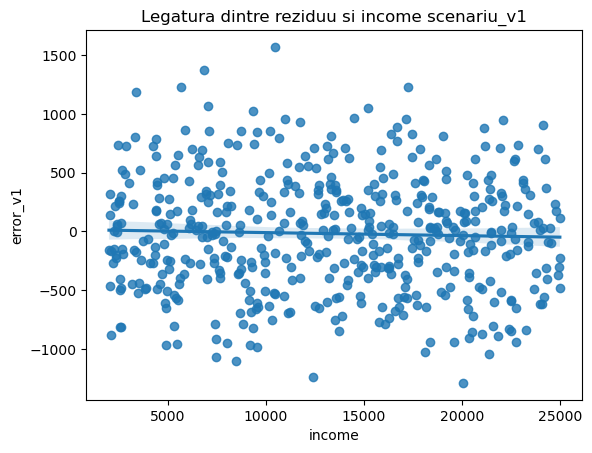

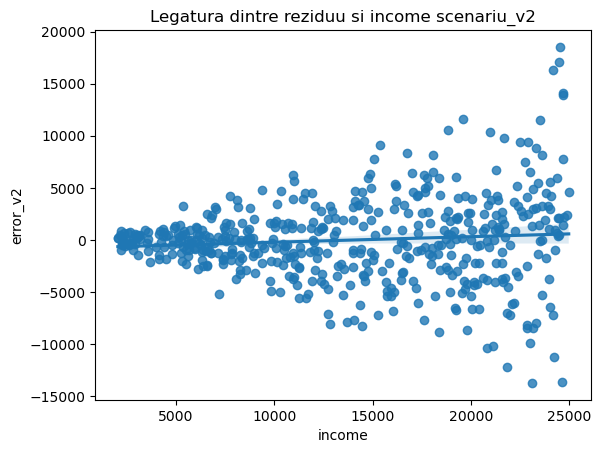

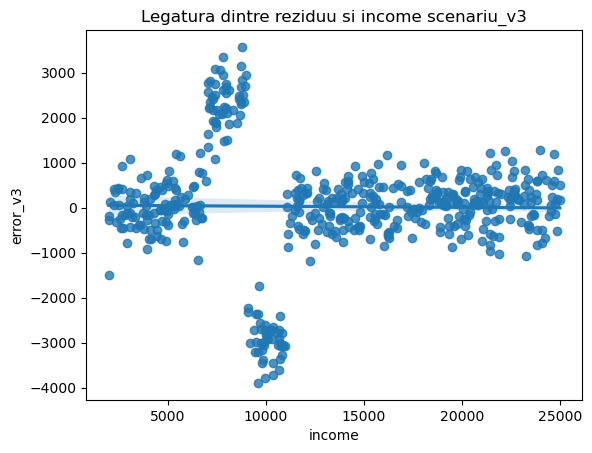

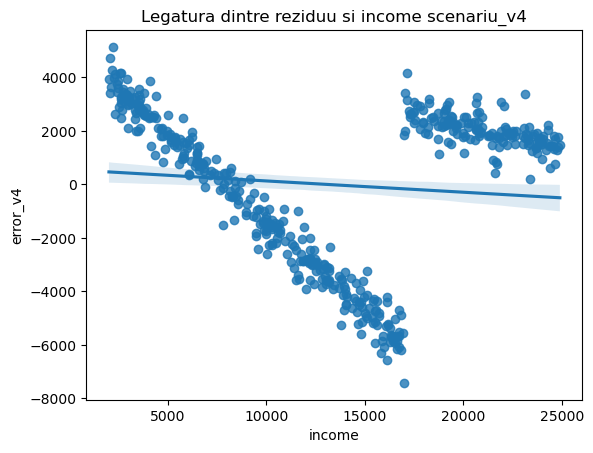

In [72]:
#liniaritate

for scenariu in scenarii_simulate_versiuni:
    relationship_plot = sns.regplot(data=df.sample(500), x=f"income",y=f"error_v{scenariu}")
    #rainbow_statistic, rainbow_pv = linear_rainbow(eval(f"model_v{scenariu}"))
    #title = f"Legatura dintre income si consumption_v{scenariu}, rainbow pv: {rainbow_pv.round(3)}"
    title = f"Legatura dintre reziduu si income scenariu_v{scenariu}"
    relationship_plot.set_title(title)
    plt.show()


### Testarea homoscedasticitatii

Testam daca distributiile erorilor conditionate de X au variantele diferite semnificativ. Cu alte cuvinte, chiar daca ele sunt usor diferite pe esantion, ele ar trebui sa fie extrase din aceleasi distributii, deci sa aiba varianta constanta. 

* H₀ (Null): Erori homoscedastice (varianta constanta)

* H₁ (Alternative): Erori heteroscedastice (varianta nu e constanta)

**Testul White**

Intuitie: Daca poti explica reziduurile obtinute initial prin X original, $X^2$, si cross product atunci are e probabil ca reziduurile sa aiba cariante diferite in functie de X. 

Statistica este $n*R^2$ si urmeaza o distributie _Chi square_ pentru H0.


Alte exemple de teste: Breusch-Pagan (BP) Test, Goldfeld-Quandt Test

### Testarea erorilor sa fie normal distribuite

Pe un esantion avem acces la reziduuri, intrebarea fundamentala este daca acest esantion de reziduuri ar fi extrase dintr-o distributie normala.

__Jarque-Bera test__

* Null Hypothesis (H₀): erorile sunt normal distribuite

* Alternative Hypothesi (H₁): erorile **nu** sunt normal distribuite

$$
JB = \frac{n}{6} \left( S^2 + \frac{(K - 3)^2}{4} \right)
$$

* n = numarul de observatii

* S = skewness

* K = kurtosis

Alte teste pentru normalitatea reziduurilor: Shapiro-Wilk Test, Kolmogorov-Smirnov (K-S) Test

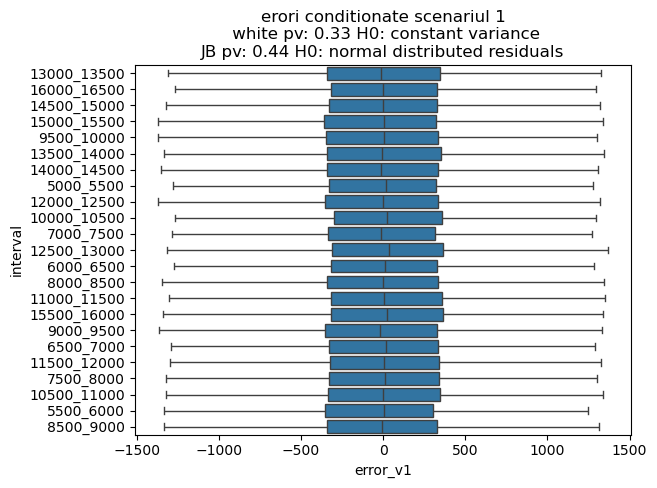

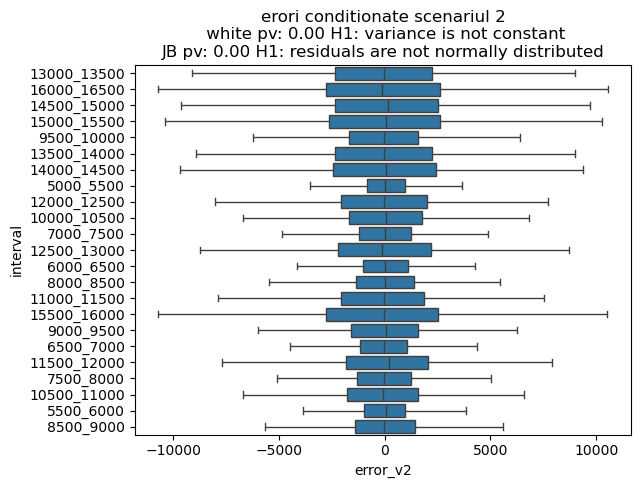

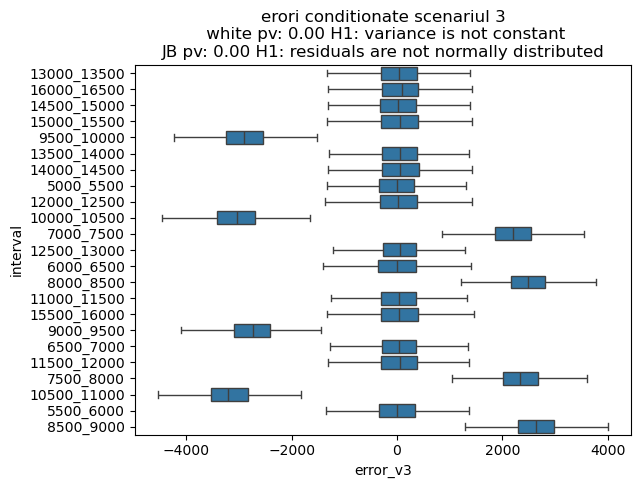

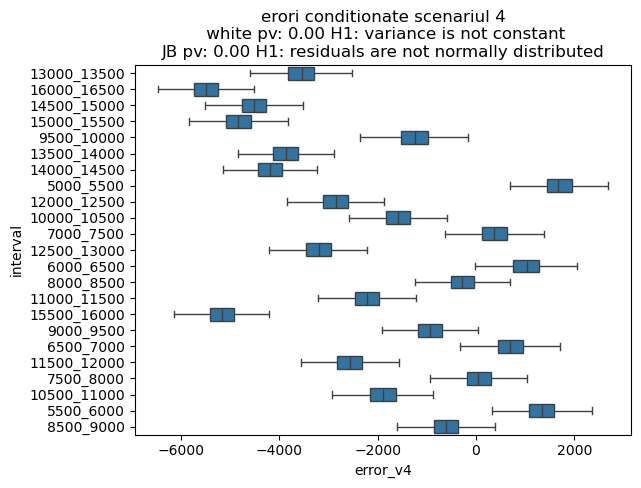

In [73]:
#Define the bins and labels
bins = range(2000, 30001, 500)
labels = [f"{i}_{i+500}" for i in range(2000, 30000, 500)]

# Add a new column with the interval labels
df['interval_income'] = pd.cut(df['income'], bins=bins, labels=labels, right=False)

for scenariu in scenarii_simulate_versiuni:
    #definim un doar un subset de intervale x pentru care sa vizualizam

    residuals = globals()[f"model_v{scenariu}"].resid
    
    #Jarque-Berra
    jarque_bera_test = sms.jarque_bera(residuals)
    JB_H_accepted = 'H0: normal distributed residuals'
    if jarque_bera_test[1]<0.05:
        JB_H_accepted = 'H1: residuals are not normally distributed'
    
    white_test = het_white(residuals, df_sample[['intercept','income']])
    W_H_accepted = 'H0: constant variance'
    if white_test[1]<0.05:
        W_H_accepted = 'H1: variance is not constant'
    
    df_sample2 = df[df['income'].between(5000,16500)].copy() #pot fi schimbate 5000 si 6000 cu alte valori
    df_sample2['interval'] = df_sample2['interval_income'].astype('str')
    erori_conditionat_boxplot = sns.boxplot(data=df_sample2, y='interval',x=f"error_v{scenariu}", showfliers=False)
    erori_conditionat_boxplot.set_title(f"erori conditionate scenariul {scenariu}\n white pv: {white_test[1]:.2f} {W_H_accepted}\nJB pv: {jarque_bera_test[1]:.2f} {JB_H_accepted}")
    plt.show()




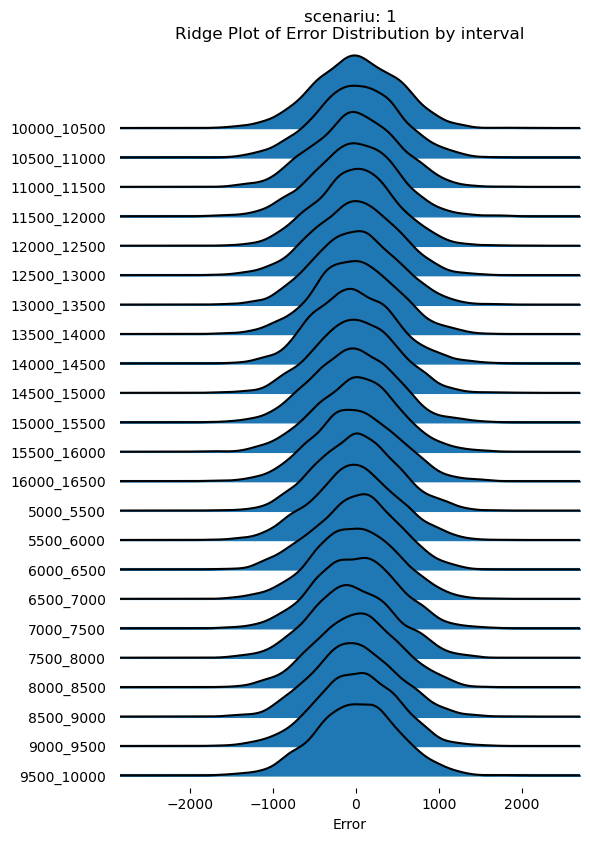

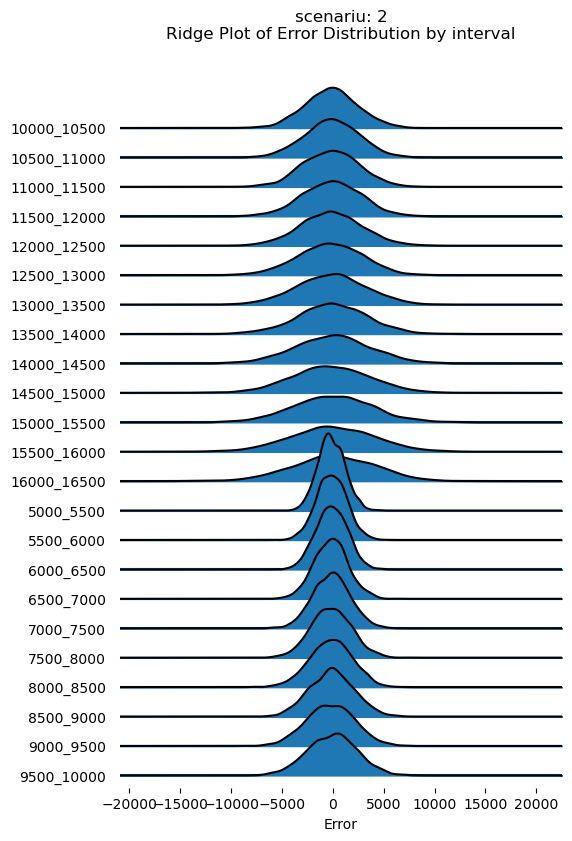

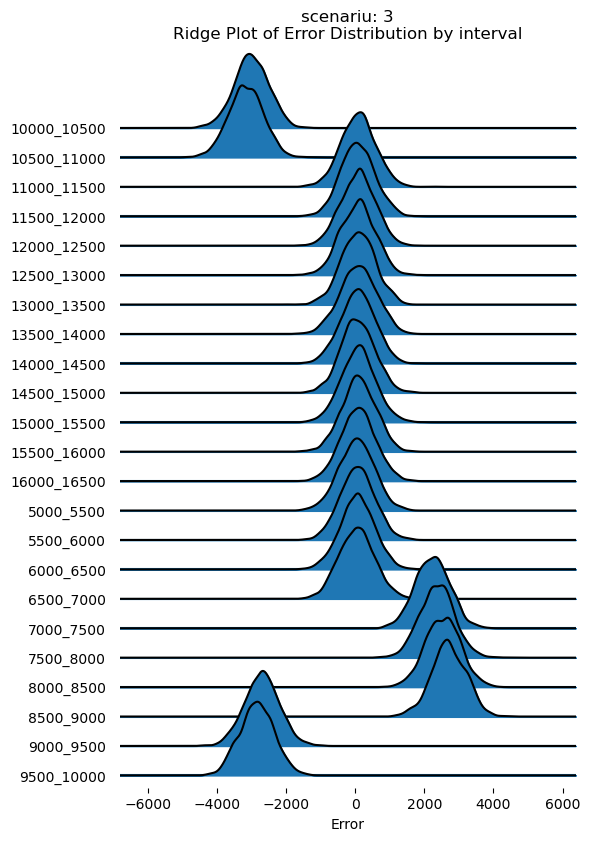

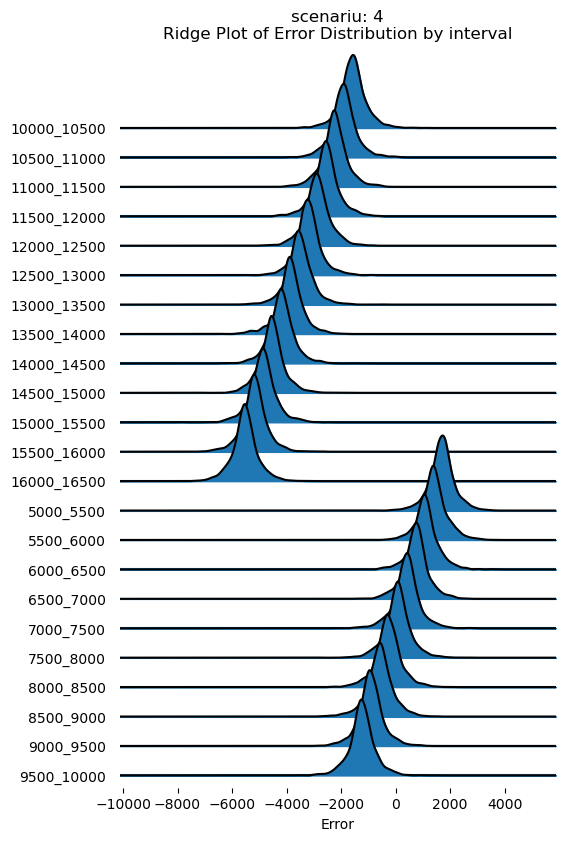

In [23]:
for scenariu in scenarii_simulate_versiuni:

    #Create a ridge plot using joypy
    fig, axes = joypy.joyplot(df_sample2, by="interval", column=f"error_v{scenariu}", figsize=(6, 8))

    # Customize the plot if needed
    plt.title(f"scenariu: {scenariu}\nRidge Plot of Error Distribution by interval")
    plt.xlabel("Error")
    plt.ylabel("Label")
    plt.show()

### Testarea autocorelatiei


- H₀ (Null Hypothesis): Nu sunt autocorelate

- H₁ (Alternative Hypothesis): Sunt autocorelate


DW
$$
DW = \frac{\sum_{t=2}^{n} (e_t - e_{t-1})^2}{\sum_{t=1}^{n} e_t^2}
$$


Alt exemplu de test: Breusch-Godfrey (BG)

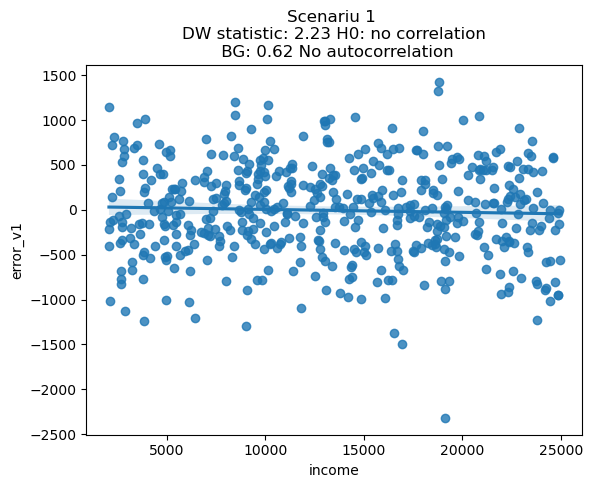

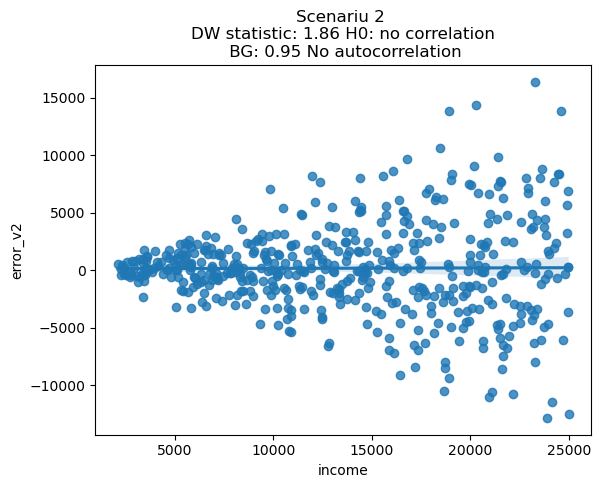

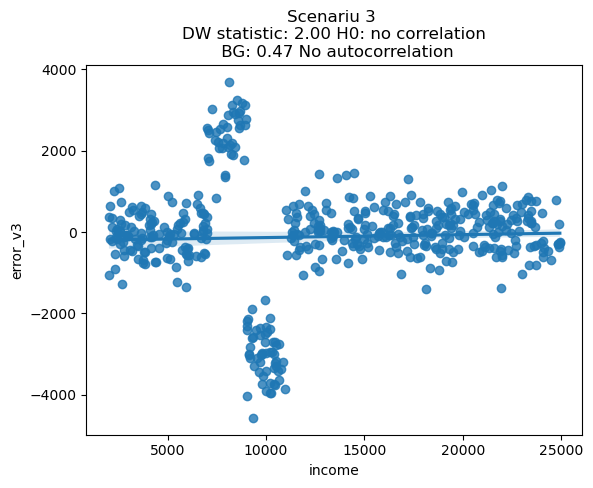

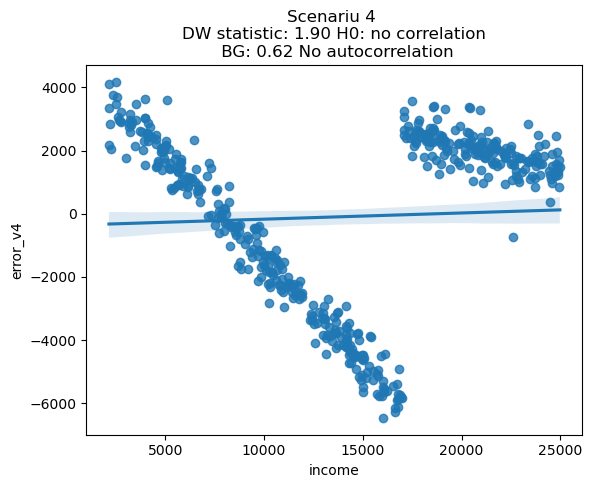

In [74]:
#variabile corelate cu erorile
for scenariu in scenarii_simulate_versiuni:
    # residuals = globals()[f"model_v{scenariu}"].resid
    temp_df = df.sample(500)
    scatter_plot_errors_x = relationship_plot = sns.regplot(data=temp_df, x='income',y=f'error_v{scenariu}')
    residuals = temp_df[f'error_v{scenariu}']
    dw_statistic = durbin_watson(residuals)
    bg_test = acorr_breusch_godfrey(globals()[f"model_v{scenariu}"], nlags=1)
    H_BG = 'No autocorrelation'
    if bg_test[1]<0.05:
        H_BG = 'Autocorrelation'

    DW_H = 'H0: no correlation'
    if dw_statistic <1.75:
        DW_H = 'H1: Positive correlation'
    if dw_statistic >2.25:
        DW_H = 'H1: Negative correlation'

    scatter_plot_errors_x.set_title(f'Scenariu {scenariu} \nDW statistic: {dw_statistic:.2f} {DW_H}\n BG: {bg_test[1]:.2f} {H_BG}')
    plt.show()